<a href="https://colab.research.google.com/github/spour/computer_vision_cellular_components/blob/main/Copy_of_HW1_classification_and_interpretability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision Homework (Part 1): Classification and Interpretability

**Welcome** to the first part of **Computer Vision HomeWork**! 

We will work on classifying and understanding biological data. In this Google Colaboratory notebook we will:
1.   implement and train from scratch a convolutional neural network to classify cellular components.
2. investigate convolutional layers of the model through visualizing weight matrices and layer activations.
3.   understand what the network has learned using saliency maps.



For the best experience, change the runtime to use a GPU accelerator. You can use a free GPU on colab by selecting:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

This assignment will be completed with Tensorflow 2.0. This library is very similar to PyTorch; you can check the differences between TensorFlow and PyTorch here: [PyTorch vs TensorFlow spotting differences](https://towardsdatascience.com/pytorch-vs-tensorflow-spotting-the-difference-25c75777377b).

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import h5py
import os

from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPool2D, BatchNormalization, Activation
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import Model

All the tasks / questions that you need to complete are denoted as following - <font color="DodgerBlue" size="4.5">**TASK 1**</font>.

# Load and explore the dataset

We will be classifying different parts of a cell using yeast single-cell data. All data that you need for this homework is shared with you, and you can access it through Google Drive.  

Link to the data folder (**cells**): https://drive.google.com/drive/folders/1lXI1EEpEOyr-_VHkAp5Gq3XkA89bIufc?usp=sharing

Please go to your **Google Drive** and open **Shared with me** tab. Find **DL2_datasets** folder, right click on it and select:
>  **Add a shortcut to Drive** → **My Drive**. 

Once you have added a shortcut, you can access the dataset files. Once you have done that - please mount your Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Below are some functions for data loading and normalization as well as exploratory data analysis.

In [ ]:
# returns data and one-hot labels in np.array format
# data is in format Number-Height-Width-Channel (NHWC)
# takes hdf5 file as input
def get_data(f):
  x, y = f['data1'], f['Index1']
  x = np.array(x).reshape(-1, 2, 64, 64)
  x = np.transpose(x, (0, 2, 3, 1))
  y = np.array(y)
  return x, y


# performs min-max normalization of the data
def normalize(x):
  x_norm = (x - np.min(x)) / (np.max(x) - np.min(x))
  return x_norm


# create a dictionary: class name -> label
# use original hdf5 file and np array of one-hot labels
def get_class_names_dict(f, y):
  y_names = np.array(f['label_names'])
  y_names = np.array([x.decode("utf-8").lower() for x in y_names])
  sparse_y = y.argmax(axis=1)
  label_names = set(y_names)
  names_dict = {}

  for name in label_names:
    idx = np.where(y_names==name)[0][0]
    names_dict[name] = sparse_y[idx]
  
  return names_dict


# plot examples of each class in the dataset 
# use data np array in NHWC format and dictionary (class name -> label)
def plot_class_examples(x, y, names_dict):
  label_names = list(names_dict)
  n_classes, n_examples = len(label_names), 5
  fig, axes = plt.subplots(nrows=n_classes, ncols=n_examples, figsize=(10, 2*len(label_names)))

  for class_name in list(names_dict):
    k = names_dict[class_name]
    axes[k, 0].set_ylabel("{} ({})".format(class_name, names_dict[class_name]))

    idx = np.where(y.argmax(axis=1)==k)[0]
    
    for j in range(n_examples):
      axes[k, j].imshow(x[idx[j],:,:,0])
      axes[k,j].set_xticks([])
      axes[k,j].set_yticks([])
  plt.show()


# get number of examples from each class
# use one-hot labels array 
def get_class_counts(y):
  unique, counts = np.unique(y.argmax(axis=1), return_counts=True)
  return dict(zip(unique, counts)) 



# plot barplot with number of samples per each label class
# this visualization should help to assess if dataset is balanced
def plot_class_counts(y):
  val_dict = get_class_counts(y)
  plt.bar(list(val_dict), list(val_dict.values()))
  plt.xticks(list(val_dict))
  plt.show()


# get a selection of samples representing each class
def get_selected_set(x, y):
  labels = sorted(set(y.argmax(axis=1)))
  selected_imgs = []

  for k in labels:
    idx = np.where(y.argmax(axis=1)==k)[0]
    selected_imgs.append(x[idx[0]:idx[0]+1])
  
  selected_imgs = np.vstack(selected_imgs)
  return selected_imgs

Let's prepare train and test data, and run some visualizations to better understand our dataset. We are working with **baker's yeast cellular data**. 

Each image in this dataset has **64x64 pixels and 2 channels** and contains a single cell. Channel 0 has a particular compartment highlighted, while channel 1 shows overall shape of the cell. As you will see in the illustrations below, cellular compartments look very different from each other. 

In [ ]:
# train / test data is in hdf5 format, we will convert it to numpy arrays and normalize
f_train = h5py.File('/content/drive/My Drive/cells/Chong_train_set.hdf5','r')
x_train, y_train = get_data(f_train)
x_train = normalize(x_train)

f_test = h5py.File('/content/drive/My Drive/cells/Chong_test_set.hdf5','r')
x_test, y_test = get_data(f_test)
x_test = normalize(x_test)

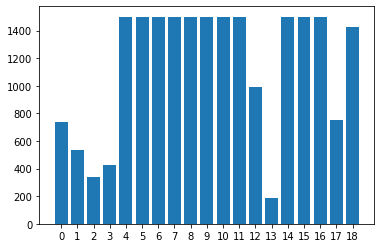

In [ ]:
# plotting class counts helps to understand if our dataset is imbalanced 
# (i.e. some classes have much more or less data than others)
# it is rare for biomedical datasets to be balanced as traditional ML datasets like MNIST and CIFAR
plot_class_counts(y_train)

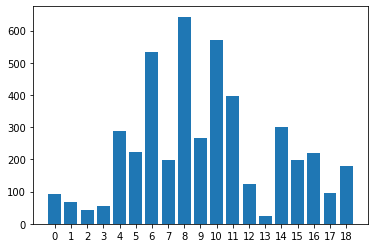

In [ ]:
plot_class_counts(y_test)

In [ ]:
# names dictionary will contain name -> label pairs 
names_dict = get_class_names_dict(f_train, y_train)
names_dict

{'nuclei': 10,
 'nucleolus': 11,
 'endosome': 5,
 'budneck': 1,
 'er': 6,
 'dead': 17,
 'cytoplasm': 4,
 'ghost': 18,
 'cellperiphery': 3,
 'mitochondria': 8,
 'vacuole': 16,
 'budtip': 2,
 'actin': 0,
 'golgi': 7,
 'peroxisome': 12,
 'nuclearperiphery': 9,
 'vacuolarmembrane': 15,
 'spindlepole': 14,
 'spindle': 13}

The dataset has 19 classes in total, each class stands for a different cellular compartment. Various biological functions happen in different compartments, for example:
* ***nucleus*** (class 10) stores all genetic information of a cell in the form of DNA, and proteins that localize to nucleus work on storing, copying and modifying DNA;
* ***cell periphery*** (class 3) is a part of the cell that interacts with outside environment, you can see how it's highlighted in green as a circular boundary of a cell.

If we can correctly classify cellular compartments, we can better understand how cells work, respond to drugs and change over time.

Let's visualize those classes!

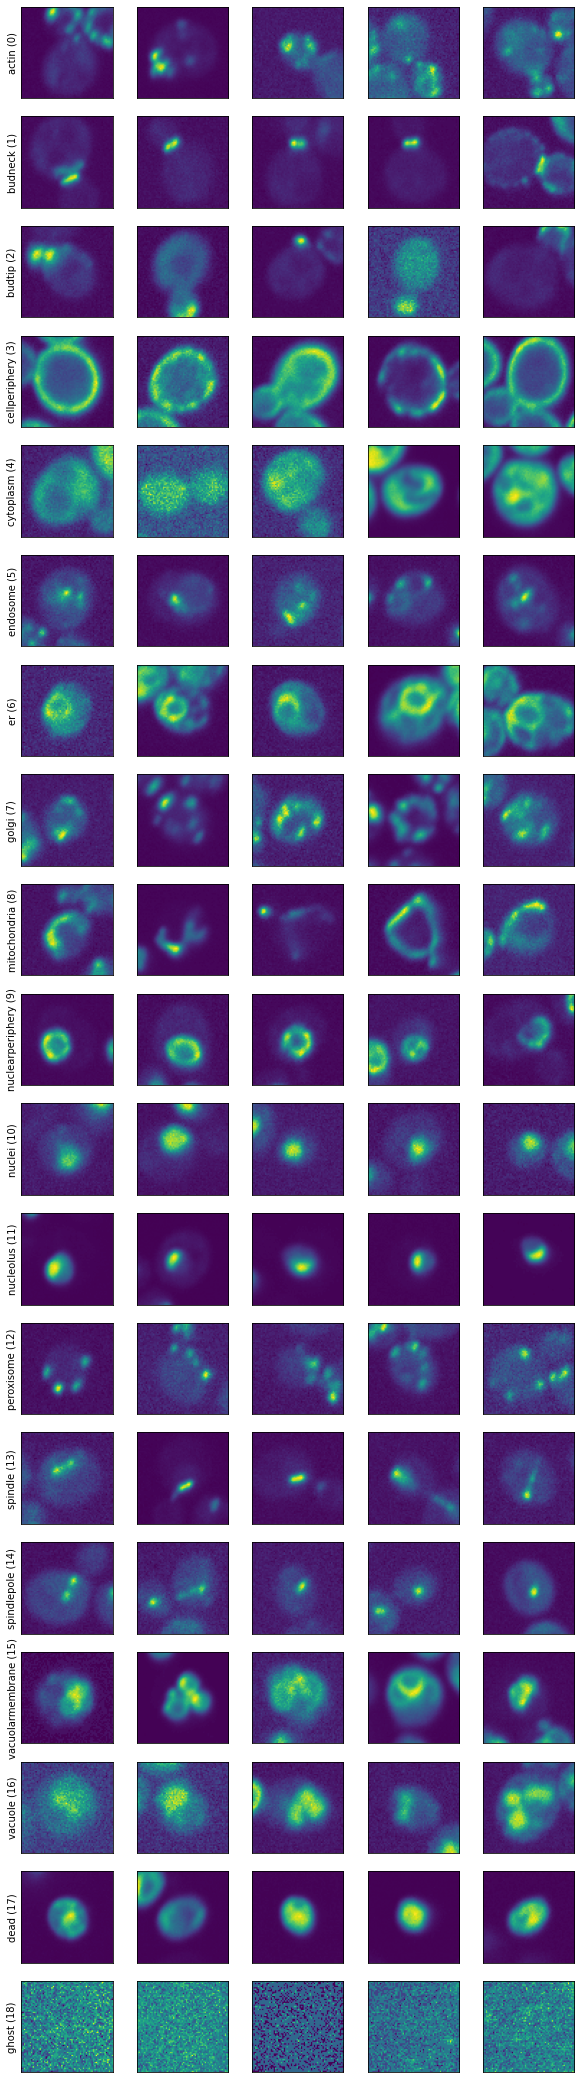

In [ ]:
plot_class_examples(x_train, y_train, names_dict)

You can see that each compartment can be easily distinguished by eye. However, in large-scale studies it's not efficient to manually label the images, because dataset sizes can reach millions of microscopy images! So we will train a convolutional neural network (CNN) to classify the images for us.

# Task 1: implementing and training a model

Our first task is to train a model to classify the 19 compartments. We will use a simple CNN with the following architecture:

input → Conv_1 (7x7 kernel, 32 filters) → MaxPool(2x2) → Conv_2 (5x5, 64) → MaxPool(2x2) → Conv_3 (3x3, 128) → MaxPool(2x2) → Dense(128) → Dropout(5%) → Dense(19) → probabilities vector output

Each convolutional layer output is followed by batch normalization and relu activations.



<font color="DodgerBlue" size="4.5">**TASK 1a**</font>: in the cell below fill in section where we initialize **self.conv3**, **self.bn3** and **self.relu3** . For self.conv3 layer you have to specify parameters from the architecture illustration above, other two layers should be defined as in previous sections.

In [ ]:
num_classes = len(list(names_dict)) # should be 19

class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()

    self.conv1 = Conv2D(filters=32, kernel_size=(7,7), strides=(1, 1), padding='valid', activation=None)
    self.bn1 = BatchNormalization()
    self.relu1 = Activation('relu')

    # we can define max pooling layer once, but use multiple times, because it doesn't have learnable parameters
    self.maxpool = MaxPool2D(pool_size=(2, 2), strides=(1, 1), padding='valid')

    self.conv2 = Conv2D(filters=64, kernel_size=(5,5), strides=(1, 1), padding='valid', activation=None)
    self.bn2 = BatchNormalization()
    self.relu2 = Activation('relu')

    # self.conv3 = ...
    # self.bn3 = ...
    # self.relu3 = ...
    self.conv3 = Conv2D(filters=128, kernel_size=(3,3), strides=(1, 1), padding='valid', activation=None)
    self.bn3 = BatchNormalization()
    self.relu3 = Activation('relu')

    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu')
    self.dropout = Dropout(0.05)
    self.d2 = Dense(num_classes)

  def nn(self, x, training=False):
    x = self.conv1(x)
    x = self.bn1(x, training=training)
    x = self.relu1(x)
    x = self.maxpool(x)
    x = self.conv2(x)
    x = self.bn2(x, training=training)
    x = self.relu2(x)
    x = self.maxpool(x)
    x = self.conv3(x)
    x = self.bn3(x, training=training)
    x = self.relu3(x)
    x = self.maxpool(x)
    x = self.flatten(x)
    x = self.d1(x)
    x = self.dropout(x)
    return x

  def call(self, x):
    x = self.nn(x)
    x = self.d2(x)
    return x

  def features(self, x):
    x = self.nn(x)
    return x

# Create an instance of the model
model = MyModel()

<font color="DodgerBlue" size="4.5">**TASK 1b**</font>: in the cell below fill in **loss_object** variable. You have 3 choices available as a hint, only one is correct.

Note that your *last Dense layer has no sigmoid activation*, this will affect your **from_logits** parameter.

In [ ]:
# loss_object = ...
# Choices:
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
#Exp: if last dense layer of model doesnt have sigmoid activation then from_logits=True is needed.
#     loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
#     loss_object = tf.keras.losses.BinaryCrossentropy((from_logits=True)
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

In [ ]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)


@tf.function
def test_step(images, labels):
  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)


In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

Now when you defined the model, loss, optimizer and training function, we can proceed to the actual training! Run the code below to train a conv net from scratch. It should take you less than 2 minutes to finish 5 epochs. 

In [ ]:
EPOCHS = 5
train_loss_list, test_loss_list, train_acc_list, test_acc_list = [], [], [], []

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  train_loss_list.append(train_loss.result())
  test_loss_list.append(test_loss.result())
  train_acc_list.append(train_accuracy.result())
  test_acc_list.append(test_accuracy.result())

  template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
  print(template.format(epoch + 1,
                        train_loss.result(),
                        train_accuracy.result() * 100,
                        test_loss.result(),
                        test_accuracy.result() * 100))

Epoch 1, Loss: 1.8016571998596191, Accuracy: 41.03372573852539, Test Loss: 1.4192677736282349, Test Accuracy: 52.524356842041016
Epoch 2, Loss: 1.246900200843811, Accuracy: 58.312767028808594, Test Loss: 1.0826952457427979, Test Accuracy: 63.57395553588867
Epoch 3, Loss: 0.918343186378479, Accuracy: 68.95622253417969, Test Loss: 0.8660885691642761, Test Accuracy: 70.10628509521484
Epoch 4, Loss: 0.7357181310653687, Accuracy: 75.07540893554688, Test Loss: 0.815482497215271, Test Accuracy: 73.3392333984375
Epoch 5, Loss: 0.5924853682518005, Accuracy: 79.70478057861328, Test Loss: 0.7242065072059631, Test Accuracy: 76.63861846923828


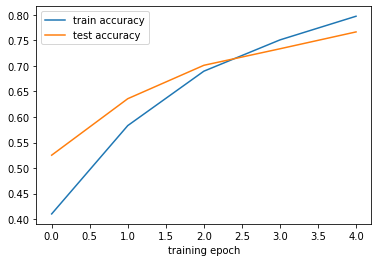

In [ ]:
plt.plot(train_acc_list, label='train accuracy')
plt.plot(test_acc_list, label='test accuracy')
plt.xlabel('training epoch')
plt.legend()

<font color="DodgerBlue" size="4.5">**TASK 1c**</font>: this is a threoretic task! You should write answers to the questions in the cell below. Your answers should be short (1-2 sentences).

To start writing, double click on the cell.

**Question 1**: Why do we have 19 nodes in our last layer?

Answer: The number of nodes in the last layer is determined by the number of classes that the model is trying to classify. In this case, the last layer has 19 nodes because there are 19 different classes that the model is trying to classify. Each node in the last layer represents a probability for a specific class, and the final output of the model is a probability vector that has a length of 19.

The length of this vector is equal to the number of classes, and the value of each element in the vector represents the probability of the input belonging to the corresponding class. The class with the highest probability is considered to be the model's prediction.

**Question 2**: Does max pooling layer have learnable parameters? Explain why.

Answer: No, max pooling layers do not have any learnable parameters. Max pooling is a form of non-linear down-sampling. It partitions the input image into a set of non-overlapping rectangles and, selects max value for each subregion.

**Question 3**: Do you observe overfitting of your model? Justify your answer with a train / test accuracy plot above. 

Answer: Slightly, when you plot the train and test accuracy of the data over the training epochs, if hte model is overfitting you see that train is much higher than test and the gap between them increases as the number of training iterations increases. 

**Question 4**: Why do we need dropout layer? 

Answer: dropout is a regularization technique that prevents overfitting by randomly setting a proportion if input units to zero during the forward pass so they don't co-adapt a lot, which is the phenomenon where the neurons learn to rely on each other too much. By setting them to zero, the other remaining neurons have to pick up the slack and makes the model more reobus to the removal of individual neurons. 

# Task 2: visualizing features

You have trained the model and it should be reaching ~70% test accuracy for 19 classes. That's great! We are happy about this result, but *we still don't know what a neural network is actually seeing*. 

We will try to understand what is happening in this black box. Let's start model's interpretation through **visualizing features**.

## Weight matrices

**We can understand first-layer features by visualizing weight matrices**. Since first convolutional layer operates directly on the input image pixels, plotting the first conv layer's weights can show patterns that the network is trying to detect with its first layer. 

Further layers are more challenging and cannot be interpreted just by looking at their weights because they operate in feature space (rather than pixel space).


We will start by plotting weight matrices from the first conv layer of the pretrained model. Let's load DenseNet121 model pretrained on ImageNet dataset, and print its first 10 layers.

In [ ]:
pretrained_model = DenseNet121(include_top=True, weights='imagenet')
pretrained_model.layers[:10]

33188688/33188688 [==============================] - 2s 0us/step


Layer #2 is the first conv layer of DenseNet121, let's try to visualize its weight matrices.

In [ ]:
conv_layer = pretrained_model.layers[2]
# weights[0] contains conv filters, weights[1] contains bias vector
conv_layer.weights[0].shape

TensorShape([7, 7, 3, 64])

In [ ]:
# function to plot weight matrices
def visualize_weight_matrices(w, title):
  rows, cols = w.shape[-1]//8, 8
  fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols, rows+1))
  fig.suptitle(title)
  for i in range(rows):
    for j in range(cols):
      k = i*rows + j
      axes[i,j].imshow(w[:,:,0,k], cmap='RdBu')
      axes[i,j].set_xticks([])
      axes[i,j].set_yticks([])

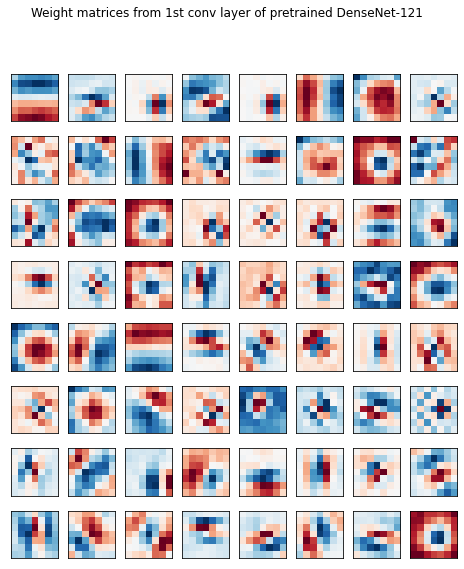

In [ ]:
w = conv_layer.weights[0].numpy()
visualize_weight_matrices(w, title="Weight matrices from 1st conv layer of pretrained DenseNet-121")

You can see how **each filter detects a different pattern**: some look for lines at different angles, some detect round shapes, and some are curves. When convolutional filter passes through the image and detects a pattern that exactly matches its shape, the highest activation value is obtained.

Now let's plot weight matrices of our cell classification model:

In [ ]:
# first let's see our model's layers
model.layers

In [ ]:
# check shape of 1st conv layer weights 
model.layers[0].weights[0].shape

TensorShape([7, 7, 2, 32])

Patterns learned by weight matrices of the cell classifier look different from pretrained DenseNet patterns. This happens because datasets that networks were trained on are very different: DenseNet was trained on real-world RGB data, while our cell classification network was trained on 2-channel microscopy data.

## Layers activations

To investigate deeper convolutional filters, we can look at **layer activations** (also called feature maps or feature activations). ***Layer activations are obtained by applying convolutional filters to the image***. Basically we are feeding an image to the network, but stop half-way to see intermediate output from prior conv layers.

Before we start, we need to do one small technical detail: build model by calling *call* method. We need to do this to ensure model's connectivity, so we can access any intermediate conv layear and get feature activations from it.

In [ ]:
inputs = tf.keras.Input(shape=(64,64,2))
model.call(inputs)

<KerasTensor: shape=(None, 19) dtype=float32 (created by layer 'dense_3')>

In [ ]:
# Print model's inputs
print(model.layers[0].input)

# Print each layer's outputs
for i in model.layers:
  print(i.output)

KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 2), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 58, 58, 32), dtype=tf.float32, name=None), name='conv2d_2/BiasAdd:0', description="created by layer 'conv2d_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 58, 58, 32), dtype=tf.float32, name=None), name='batch_normalization_2/FusedBatchNormV3:0', description="created by layer 'batch_normalization_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 58, 58, 32), dtype=tf.float32, name=None), name='activation_2/Relu:0', description="created by layer 'activation_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 57, 57, 32), dtype=tf.float32, name=None), name='max_pooling2d_1/MaxPool:0', description="created by layer 'max_pooling2d_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 53, 53, 64), dtype=tf.float32, name=None), name='conv2d_3/BiasAdd:0', description="created by layer 'conv2d_3'")


We have three convolutional layers in our cell classification model. Let's print features activations for each of them. To do this, we will define an "shortened" model that starts with input layer and ends at conv layer.

**Let's see how feature activations look for the first conv layer** of our network. We will pick one random image from out training set and pass it through the network up to the first conv layer, and then investigate the activations.

In [ ]:
# define a shortened feature model
feature_model = Model(inputs=model.layers[0].input, outputs=model.layers[0].output)
feature_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 2)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 58, 58, 32)        3168      
                                                                 
Total params: 3,168
Trainable params: 3,168
Non-trainable params: 0
_________________________________________________________________


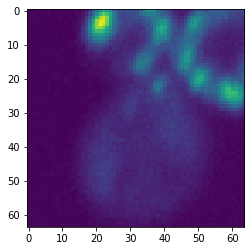

In [ ]:
x = x_train[70:71]
plt.imshow(x[0,:,:,0])
plt.show()

In [ ]:
activations = feature_model(x)
activations.shape

TensorShape([1, 58, 58, 32])

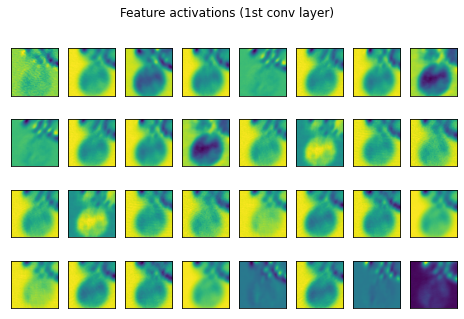

In [ ]:
def plot_activations(activations, title):
  rows, cols = 4, 8
  fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(8, 5))
  fig.suptitle(title)
  for i in range(rows):
    for j in range(cols):
      k = i*rows + j
      axes[i,j].imshow(activations[0,:,:,k])
      axes[i,j].set_xticks([])
      axes[i,j].set_yticks([])
  

title = "Feature activations (1st conv layer)"
activations= activations.numpy()
plot_activations(activations, title)

Similarly, we can plot feature activations for other convolutional layers.

<font color="DodgerBlue" size="4.5">**TASK 2b**</font>: plot feature activations of 2nd convolutional layer of your CNN by finishing the starter code below.

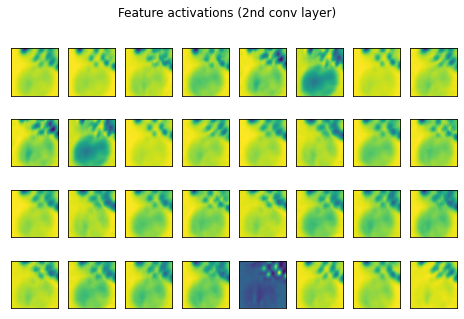

In [ ]:
# feature_model = ...
# Create a feature model that only includes the layers up to the second convolutional layer
feature_model = Model(inputs=model.layers[0].input, outputs=model.layers[4].output)
activations = feature_model(x)

title = "Feature activations (2nd conv layer)"
plot_activations(activations.numpy(), title)

<font color="DodgerBlue" size="4.5">**TASK 2c**</font>: summarize in 3-4 sentences differences between model interpretation through weight matrices and feature activations.

interpreting using weights involves analyzing learned weights of the model's layers to see how it's making predictions, but feature activations refer to the output of a specific layer in the mdoel which shows how it is processing the input data. So weight matrices show how the model is making predictions but feature activations show how it is processing the input data and are specific to layers.

In [ ]:
model.layers

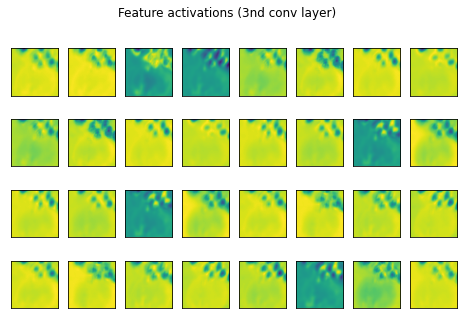

In [ ]:
# feature_model = ...
# Create a feature model that only includes the layers up to the second convolutional layer
feature_model = Model(inputs=model.layers[0].input, outputs=model.layers[7].output)
activations = feature_model(x)

title = "Feature activations (3nd conv layer)"
plot_activations(activations.numpy(), title)

# Task 3: gradient maps

In this task you will investigate model through gradient maps. **Gradient map (also called sensitivity map) shows how much individual pixels in an image contribute to the prediction**.

## Vanilla gradient map

Let's start with the original version of gradient map. We have trained a convolutional network that gives score $S_{c}(I)$ for an image $I$ belonging to a class $c$ ($S_{c}(I)$ is logit). Final classification result will be class with maximal score: $$class(I) = argmax_{c \in C} S_{c}(I) $$.

In case of CNNs, score $S_{c}(I)$ is a highly non-linear function of the input image $I$, but we can approximate it with first-order Taylor expansion:

$$S_{c}(I) \approx w^T I + b$$

Hence, class sensitivity map for image $I$ is defined as:

$$M_{c} = \frac{\partial S_{c}}{\partial I}$$

Sensitivity map $M_{c}$ will have the same shape as image $I$ and basically answers the question ***How much does change in every pixel makes change in network's prediction of class $c$?***

You can read more about gradient maps in this paper: https://arxiv.org/pdf/1312.6034v2.pdf

<font color="DodgerBlue" size="4.5">**TASK 3a**</font>: finish the function below for calculating vanilla gradient map.

In [ ]:
# vanilla gradient map code
def get_grad(x):
  img = tf.Variable(x, dtype=float)

  with tf.GradientTape() as tape:
      prediction = model(img, training=False)
      class_idxs_sorted = np.argsort(prediction.numpy().flatten())[::-1]
      pred = prediction[0][class_idxs_sorted[0]]
      
  grads =  tape.gradient(pred, img)
  # hint: to denote dx/dy use tape.gradient(x, y)
  return grads


# get absolute value of the gradient
def abs(gradients):
  abs_grads = tf.math.abs(gradients)
  return abs_grads


# normalize gradient to range between 0 and 1
def norm_grad(grad_x):
  abs_grads = abs(grad_x)
  grad_max_ = np.max(abs_grads, axis=3)[0]
  arr_min, arr_max  = np.min(grad_max_), np.max(grad_max_)
  normalized_grad = (grad_max_ - arr_min) / (arr_max - arr_min + 1e-18)
  return normalized_grad.reshape(1,64,64,1)

In [ ]:
def plot_sensitivity_maps(list_of_arrs, arr_names):
  N = list_of_arrs[0].shape[0]
  cols = len(list_of_arrs)
  fig, axes = plt.subplots(nrows=N, ncols=cols, figsize=(cols*3, N*3))
  for j in range(cols):
    axes[0, j].set_title(arr_names[j])

  for i in range(N):
    for j in range(cols):
      if j==0: cmap = 'viridis'
      else: cmap = 'jet'
      axes[i, j].imshow(list_of_arrs[j][i,:,:,0], cmap=cmap)
      axes[i, j].set_xticks([])
      axes[i, j].set_yticks([])
  plt.show()

Let's plot one of the images and compute a sensitivity map for it.

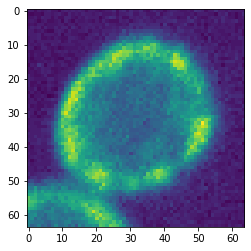

In [ ]:
# select one image
image = x_train[79:80]
plt.imshow(image[0,:,:,0])

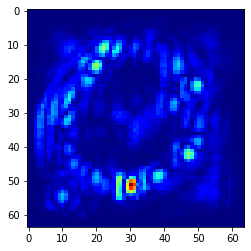

In [ ]:
# compute saliency map for this image
gradients = get_grad(image)
gradients = norm_grad(gradients)
plt.imshow(gradients[0,:,:,0], cmap='jet')

You can see how important parts of the image are more bright in its gradient map. That's a nice way of investigating "*what network is looking at*"! Sensitivity maps are widely used in model interpretability studies.

Now let's compute sensitivity maps for the first 20 images of our training set.

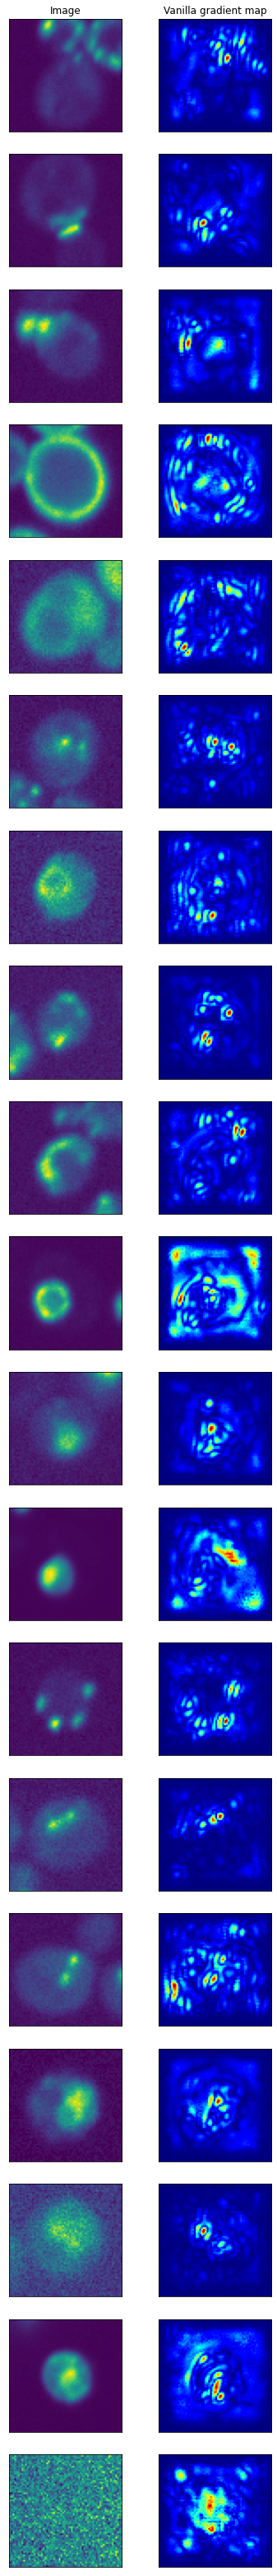

In [ ]:
x = get_selected_set(x_train, y_train)
vanilla_grad_x = [get_grad(x[i:i+1]) for i in range(x.shape[0])]
vanilla_grad_x = np.vstack([norm_grad(g) for g in vanilla_grad_x])
plot_sensitivity_maps([x, vanilla_grad_x], ["Image", "Vanilla gradient map"])

Well done! You have just tried a **vanilla sensitivity map approach** which involves computing a gradient of top-scoring prediction with input image. It worked very well, but still has some disadvantages:
* sensitivity maps based on raw gradients are
typically visually noisy;
* sensitivity maps are susceptible to the inherent noise of the image and can change a lot because of that.

## SmoothGrad
A simple but efficient method to make gradient maps sharper and less noisy is **SmoothGrad**.  

***SmoothGrad works by averaging several gradient maps*** the following way:

1.  make N slightly different copies of the same image by adding Gaussian noise to the input image;
2.  compute N vanilla gradient maps for the "noisy" images;
3.  get an averaged gradient map from N vanilla gradient maps.

Mathematically SmoothGrad sensitivity map can be written as:
$$ \hat{M_{c}}(I) = \frac{1}{n} \sum_{1}^n{M_{c}(I + \mathcal{N}(0, \sigma))}$$

Where $I$ is our input image and $M_{c}$ is vanilla gradient map (defined one section above). 

**The idea behind SmoothGrad is to make the sensitivity map robust to noise**: pixels which are important for the prediction will get high values in gradient maps from different noise additions. You can read the original SmoothGrad paper here: https://arxiv.org/pdf/1706.03825.pdf

<font color="DodgerBlue" size="4.5">**TASK 3b**</font>: finish the function below for calculating SmoothGrad gradient map.

In [ ]:
# function to compute SmoothGrad sensitivity map of the image
def smooth_grad(x, stdev_spread=0.1, n=30, clip_values=True):
  stdev = stdev_spread * (np.max(x) - np.min(x))
  total_gradients = np.zeros_like(x)
  
  for i in range(n):
    noise = np.random.normal(0, stdev, x.shape)
    grads = get_grad(x + noise)
    # hint: use get_grad() function to calculate grads, 
    #       recall that you want to calculate gradient map of image + noise
    if clip_values: 
      grads = np.clip(grads, 0.99*np.min(grads), 0.99*np.max(grads))
    
    total_gradients += grads 
    # hint: here you are summing up previous gradient maps (to average them at the end)
  
  grad_map =  total_gradients / n 
  # get the average of total_gradients (divide them by number of "noisy" images you used)
  return grad_map

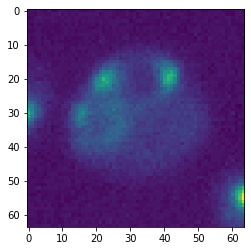

In [ ]:
k=10
x = x_train[k:k+1]
plt.imshow(x[0,:,:,0])

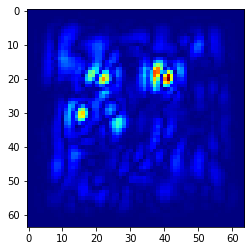

In [ ]:
s_grad = smooth_grad(x)
plt.imshow(norm_grad(s_grad)[0,:,:,0], cmap='jet')

Let's plot vanilla gradient maps and SmoothGrad sensitivity maps for some of the train data images.

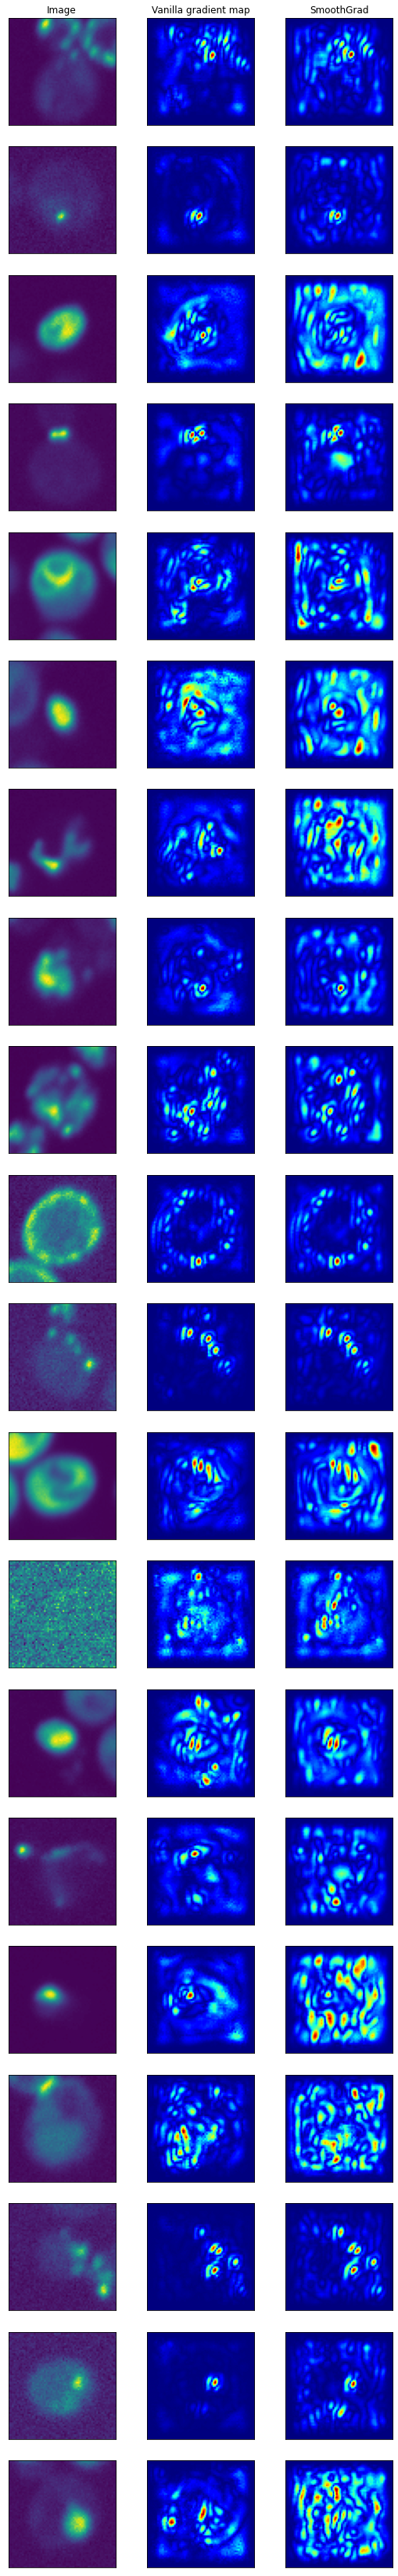

In [ ]:
x = x_train[70:90]
vanilla_grad_x = [get_grad(x[i:i+1]) for i in range(x.shape[0])]
vanilla_grad_x = np.vstack([norm_grad(g) for g in vanilla_grad_x])

smooth_grad_x = [smooth_grad(x[i:i+1]) for i in range(x.shape[0])]
smooth_grad_x = np.vstack([norm_grad(g) for g in smooth_grad_x])

plot_sensitivity_maps([x, vanilla_grad_x, smooth_grad_x], ["Image", "Vanilla gradient map", "SmoothGrad"])

<font color="DodgerBlue" size="4.5">**TASK 3c**</font>: answer the questions below (4-5 sentences is enough).
  * discuss advantages of sensitivity maps for model interpretation

  Ans: sensitivity maps can be used to identify the input features that have the most influence on the output of a neural network, theyre easy to understand since its visual and you can use them to identify the input features that might have caused the model to make a mistake so you can improve the model after. 
  * explain why SmoothGrad is better than vanilla gradient maps.
  SmoothGrad is less noisy than vanilla grad so it can help reduce noise in the sensitivity maps. Vanilla tends to be really sensitive to noise in the input because the gradients of the output with respect to the input are calculates based on input itself which can vary a lot. Smoothgrad is robust against this by adding a bit of random noise to the input and then averaging the gradients of the output wrt to the input multiiple times